# Optimization in few dimensions

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/convex_optimization_univariate.ipynb)

In [2]:
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

## Import plot settings (optional)
import requests
code = requests.get("https://raw.githubusercontent.com/williamgilpin/cphy/main/cphy/template.py", timeout=10).text
exec(code, globals(), globals())

### Optimization

The cost function, fitness, or loss is usually a scalar function that measure performance in a task. Examples include:
+ The energy of a physical system
+ Error of a neural network on a particular batch of training data
+ The fitness of a genotype
+ The stability of a folded protein configuration
+ The energy of a given spin configuration

In machine learning, loss functions are usually conditioned on a finite dataset, forming the *empirical risk*. For example, the mean squared error widely used in regression is given by

$$
    L(\theta) = \frac{1}{N} \sum_{i=1}^N (y_i - f(x_i; \theta))^2
$$
where $N$ is the number of data points, $x_i$ is the input, $y_i$ is the target, and $f_\theta(x_i)$ is the prediction of a statistical model parameterized by $\theta$. This loss function depends on both the model parameters $\theta$ and the particular data $(x_i, y_i)$. However, conditioned on a given dataset, the loss is a continuous scalar function of the model parameters, and we can ask the question of how to choose the parameters to minimize the loss. However, with a large amount of data, the empirical risk converges to the true risk, which is a property of the underlying data distribution (which may be a stationary distribution, and thus constant).

<br>
<br>
<br>

Global optimization is the problem of finding the absolute minimum of a cost function. The easiest way to do this is to query the function at every point in the input space, and return the minimum value. However, this can often be infeasible, since the input space is often high-dimensional and continuous. However, if we can constrain the class of functions that describe our optimization problem, we may be able to discover the global minimum, and prove that it is indeed the global minimum, without exhaustive search. **Convex optimization** is one class of problems with particularly nice properties, because any local minimum that we discover for a convex loss is also a global minimum.

There are diverse examples of *non-convex* optimization problems, for which there are fewer guarantees that any local minimum we find is a global minimum, or even a particularly deep minimum on a landscape. The absolute hardest non-convex problems are NP-hard, meaning that the time required to solve them scales exponentially with problem size. This condition is equivalent to the case where there is no more efficient way to find the global minimum than checking every single configuration. Examples of NP-hard problems include the traveling salesman problem, integer programming, finding the ground state of a spin glass, many Sudoku puzzles, and even certain levels in [Donkey Kong Country](https://doi.org/10.1016/j.tcs.2015.02.037).


Text(0.5, 0, 'x')

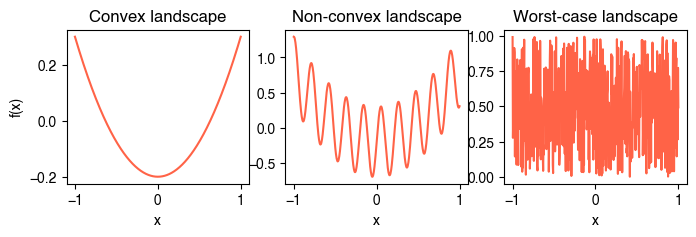

In [3]:
xx = np.linspace(-1, 1, 500)

f_con = lambda x: 0.5 * x**2 - 0.2
f_noncon = lambda x :  x**2 + 0.5 * np.sin(30 * x) - 0.2

plt.figure(figsize=(8, 2))
plt.subplot(1, 3, 1)
plt.plot(xx, f_con(xx))
plt.title('Convex landscape')
plt.xlabel('x')
plt.ylabel('f(x)')

plt.subplot(1, 3, 2)
plt.plot(xx, f_noncon(xx))
plt.title('Non-convex landscape')
plt.xlabel('x')


plt.subplot(1, 3, 3)
plt.plot(xx, np.random.uniform(size=xx.shape[0]))
plt.title('Worst-case landscape')
plt.xlabel('x')


# One dimension is special: rootfinding

Given some *smooth* function $f(x)$, and we want to calculate the global minimum (convex), or at least the nearest local minimum to a starting point in the case of non-convex functions. In one dimension, if we use our standard approach of finding the nearest point at which $f' = 0$, reducing the calculation to an equality, for which we can use rootfinding methods to find the minimum.

$$
    x^* = \arg \min_x f(x) \implies f'(x^*) = 0
$$

Recall that, for a given target precision $\epsilon$, we can localize a the root of a convex function to an interval of width $\epsilon$ using binary search, with a cost of $O(\log(1/\epsilon))$ evaluations of the function. For a non-convex univariate function $f(x)$ has a complex form, we cannot necessarily find all of the roots without global search, for which the cost of localizing each root to within $\epsilon$ is $O(1/\epsilon)$ evaluations of the function. However, if we can approximate the function as a polynomial with multiple roots, we can find the roots one at a time using the [Durand-Kerner method](https://en.wikipedia.org/wiki/Durand%E2%80%93Kerner_method).

Text(0.5, 0, 'x')

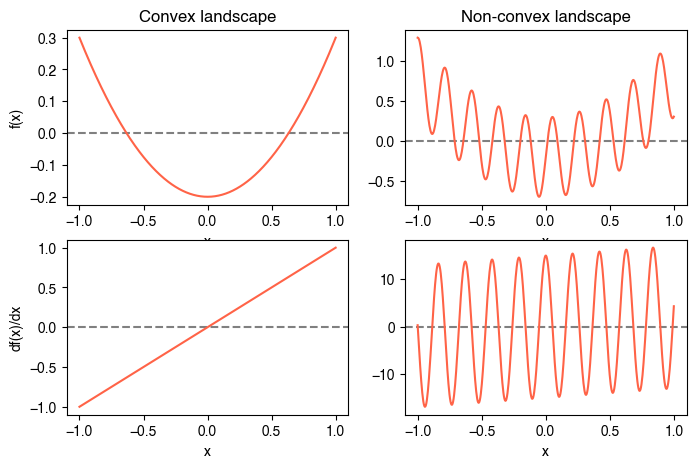

In [4]:
xx = np.linspace(-1, 1, 500)

f_con = lambda x: 0.5 * x**2 - 0.2
df_con = lambda x: x
f_noncon = lambda x :  x**2 + 0.5 * np.sin(30 * x) - 0.2
df_noncon = lambda x: 2 * x + 15 * np.cos(30 * x)

plt.figure(figsize=(8, 5))

plt.subplot(2, 2, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.plot(xx, f_con(xx))
plt.title('Convex landscape')
plt.xlabel('x')
plt.ylabel('f(x)')

plt.subplot(2, 2, 2)
plt.axhline(0, color='gray', linestyle='--')
plt.plot(xx, f_noncon(xx))
plt.title('Non-convex landscape')
plt.xlabel('x')

plt.subplot(2, 2, 3)
plt.axhline(0, color='gray', linestyle='--')
plt.plot(xx, df_con(xx))
plt.xlabel('x')
plt.ylabel('df(x)/dx')

plt.subplot(2, 2, 4)
plt.axhline(0, color='gray', linestyle='--')
plt.plot(xx, df_noncon(xx))
plt.xlabel('x')


While the locations of roots are obvious from looking at these plots, remember that the process of drawing the plot itself is a global search that requires $O(N)$ evaluations of the function, where $N$ is the resolution of the plot along the x-axis.
<br><br><br><br><br><br><br><br><br><br>




### Gradient descent is a local optimizer

Gradient descent is a first-order method that resembles a ball rolling down a landscape. It has several appealing properties. It is considered a first-order method because it only requires the first derivative of the loss function locally $f'(x)$, rather than higher-order derivatives ($f''(x)$, etc.) or a global search over the landscape.

Starting from an arbitrary point on the landscape, gradient descent consists of taking steps along the direction of steepest descent

$$
    x \leftarrow x - \eta \dfrac{df}{dx}
$$

The learning rate $\eta \in \mathbb{R}$ is a "hyperparameter" that we choose based on problem knowledge. If this is set too large, we can get stuck in oscillating solutions around the optima. If we set it too small, and the system takes a long time to converge.

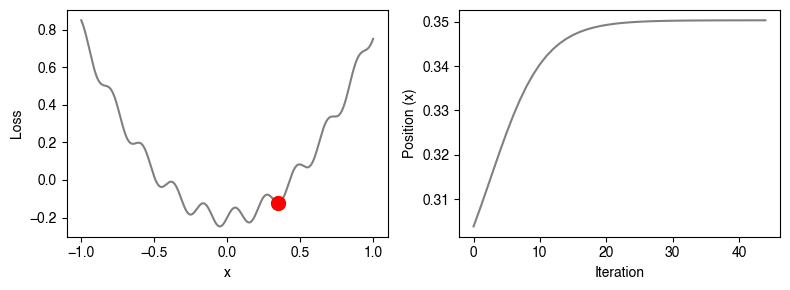

In [6]:
class GradientDescentOptimizer:

    def __init__(self, learning_rate=0.1, max_iter=1000, tolerance=1e-6, store_history=False):

        self.learning_rate = learning_rate

        self.max_iter = max_iter
        self.tolerance = tolerance
        self.store_history = store_history
        if self.store_history:
            self.history = list()

    def optimize(self, df, x0):
        x = x0
        for i in range(self.max_iter):

            x_new = x - self.learning_rate * df(x)

            if np.linalg.norm(x_new - x) < self.tolerance:
                break
            
            x = x_new

            if self.store_history:
                self.history.append(x_new)

        return x

# def loss(x):
#     return 0.5 * x**2 - 0.2

# loss = lambda x: 0.5 * x**2 - 0.2
# loss_grad = lambda x: x

loss = lambda x: x**2 + 0.05 * np.sin(30 * x) - 0.2
loss_grad = lambda x: 2 * x + 0.05 * 30 * np.cos(30 * x)

# # optimizer = GradientDescentOptimizer(store_history=True, learning_rate=2.0)
optimizer = GradientDescentOptimizer(store_history=True, learning_rate=0.005)
x_opt = optimizer.optimize(loss_grad, np.array(0.3))

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(xx, loss(xx), color='gray')
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(optimizer.history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('Position (x)')

plt.tight_layout()

We can repeat this for many different starting points, to see how inital conditions can affect the optimization process. Because our optimization code is vectorized, we can run all of these different optimizations all at once. This is not quite in parallel (vectorization simply reduces the overhead of the loop), but it is much faster than materializing an explicit for loop.

Text(0, 0.5, 'Loss')

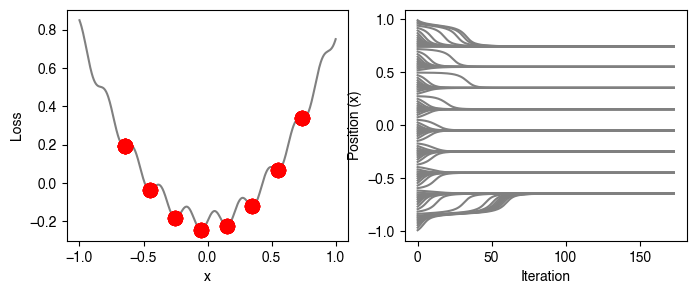

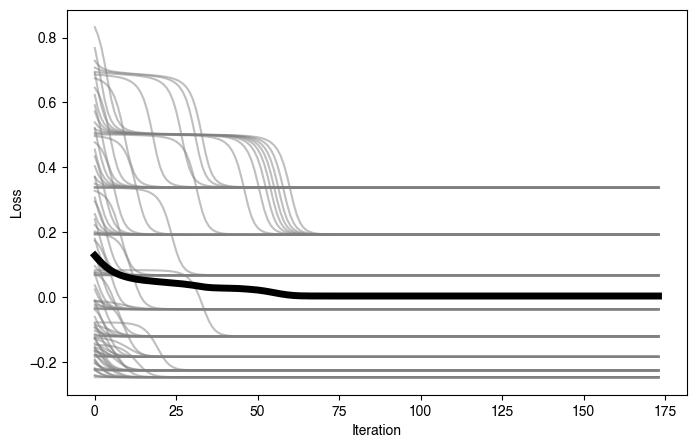

In [7]:
starting_points = np.linspace(-1, 1, 100)
optimizer = GradientDescentOptimizer(store_history=True, learning_rate=0.005)
x_opt = optimizer.optimize(loss_grad, starting_points)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(xx, loss(xx), color='gray')
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(optimizer.history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('Position (x)')

all_losses = loss(np.array(optimizer.history))
plt.figure(figsize=(8, 5))
plt.plot(all_losses, color='gray', alpha=0.5)
plt.plot(np.mean(all_losses, axis=1), color='black', lw=5)
plt.xlabel('Iteration')
plt.ylabel('Loss')


In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Precompute the static background curve
yline = loss(xx)

fig, ax = plt.subplots(figsize=(7, 5))
(bg_line,) = ax.plot(xx, yline, lw=2, color='gray')
ax.set_xlabel("x")
ax.set_ylabel("Loss")
ax.set_xlim(np.min(xx), np.max(xx))
ax.set_ylim(np.min(yline), np.max(yline))

# Moving point (and optional trace)
(dot,) = ax.plot([], [], "ro", ms=6)
# (trace,) = ax.plot([], [], "r-", alpha=0.35)
_xtrace, _ytrace = [], []

def init():
    dot.set_data([], [])
    # trace.set_data([], [])
    _xtrace.clear(); _ytrace.clear()
    return (dot, )

def update(k):
    xk = optimizer.history[k]
    yk = loss(xk)
    dot.set_data([xk], [yk])

    # optional breadcrumb trail
    _xtrace.append(xk); _ytrace.append(yk)
    # trace.set_data(_xtrace, _ytrace)

    return (dot, )

ani = FuncAnimation(
    fig,
    update,
    frames=len(optimizer.history),
    init_func=init,
    interval=100,
    blit=True,
    repeat=True,
)
plt.close(fig)


# In-notebook video (MP4 in HTML5). For smaller notebooks, to_jshtml() is also fine.
HTML(ani.to_html5_video())

### Hyperparameters in optimization

The solution of our optimization problem is the final "state," $x$ of the optimizer. However, the optimization process is determined by a variety of choices that we make when we set up our optimizer. These choices are called *hyperparameters*, in contrast to the optimizer state (the parameters). Examples of hyperparameters include:

+ Learning rate
+ Momentum
+ Initialization
+ The choice of optimization algorithm itself
+ The precision of the numbers used to represent the parameters

We can try varying these hyperparameters to see how they affect the optimization process. In general, hyperparameter tuning is a meta-optimization problem.

Text(0, 0.5, 'x')

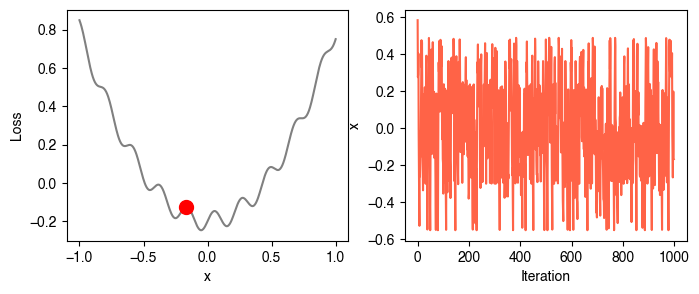

In [13]:
## Solve optimization
optimizer = GradientDescentOptimizer(learning_rate=0.2, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.7)

## Plot loss
xx = np.linspace(-1, 1, 500)


plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(xx, loss(xx), color='gray')
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

Text(0, 0.5, 'Loss')

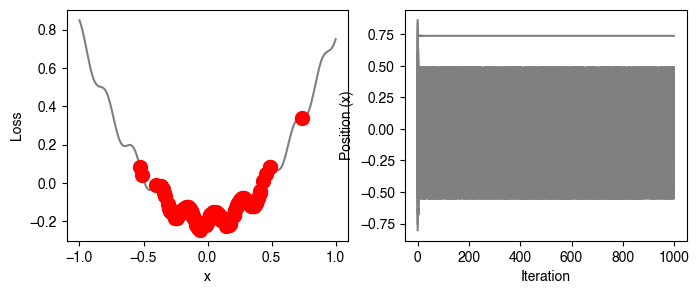

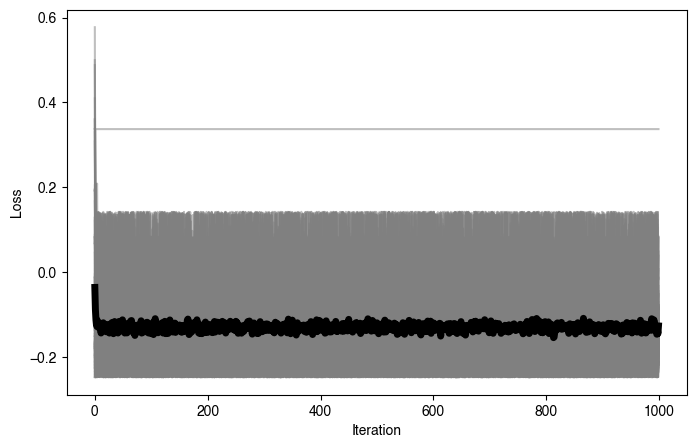

In [14]:
starting_points = np.linspace(-1, 1, 100)
optimizer = GradientDescentOptimizer(learning_rate=0.2, store_history=True)
x_opt = optimizer.optimize(loss_grad, starting_points)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(xx, loss(xx), color='gray')
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(optimizer.history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('Position (x)')

all_losses = loss(np.array(optimizer.history))
plt.figure(figsize=(8, 5))
plt.plot(all_losses, color='gray', alpha=0.5)
plt.plot(np.mean(all_losses, axis=1), color='black', lw=5)
plt.xlabel('Iteration')
plt.ylabel('Loss')


In [15]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Precompute the static background curve
yline = loss(xx)

fig, ax = plt.subplots(figsize=(7, 5))
(bg_line,) = ax.plot(xx, yline, lw=2, color='gray')
ax.set_xlabel("x")
ax.set_ylabel("Loss")
ax.set_xlim(np.min(xx), np.max(xx))
ax.set_ylim(np.min(yline), np.max(yline))

# Moving point (and optional trace)
(dot,) = ax.plot([], [], "ro", ms=6)
# (trace,) = ax.plot([], [], "r-", alpha=0.35)
_xtrace, _ytrace = [], []

def init():
    dot.set_data([], [])
    # trace.set_data([], [])
    _xtrace.clear(); _ytrace.clear()
    return (dot, )

def update(k):
    xk = optimizer.history[k]
    yk = loss(xk)
    dot.set_data([xk], [yk])

    # optional breadcrumb trail
    _xtrace.append(xk); _ytrace.append(yk)
    # trace.set_data(_xtrace, _ytrace)

    return (dot, )

ani = FuncAnimation(
    fig,
    update,
    frames=len(optimizer.history),
    init_func=init,
    interval=100,
    blit=True,
    repeat=True,
)
plt.close(fig)


# In-notebook video (MP4 in HTML5). For smaller notebooks, to_jshtml() is also fine.
HTML(ani.to_html5_video())

We can see a contradiction has emerged. The optimizer looks like it went poorly at high learning rate, since few of the initial conditions converge, and the optimizer appears to oscillate erratically. However, looking at the loss curves, it looks like this erratic behavior led to better minima than the smoother dynamics at lower learning rates. More mysteriously, the dynamics oscillate erratically, yet our dynamics are purely deterministic,

$$
    x_{t+1} = x_t - \eta \dfrac{df}{dx}
$$

Where does this "thermal" noise come from in our deterministic dynamics?

<br><br><br><br><br>





### Gradient descent approximates a continuous-time dynamics only at small learning rates

Suppose that we have an energy function $V(x)$. The dynamics of a particle moving in this potential is given by Newton's second law,
$$
    m \ddot{x} = -\gamma \dot{x} -\dfrac{dV}{dx}
$$
where $m$ is the mass of the particle, and $\gamma$ is a friction coefficient. In the limit of large friction $\gamma \gg m$, we can ignore the inertial term $m \ddot{x}$, and rearranging to give a first-order differential equation
$$
    \dot{x} = -\dfrac{1}{\gamma} \dfrac{dV}{dx}
$$
In discrete time, we can approximate the time derivative as a finite difference,
$$
    \dfrac{x(t+\Delta t) - x(t)}{\Delta t} = -\dfrac{1}{\gamma} \dfrac{dV}{dx}
$$

Rearranging gives
$$
    x(t+\Delta t) = x(t) - \dfrac{\Delta t}{\gamma} \dfrac{dV}{dx}
$$

we can see that the learning rate $\eta = \Delta t / \gamma$ is determined by the friction and the effective timestep. Interestingly, we see above that, when the learning rate is large, the behavior of the discrete-time dynamics starts to depart from the continuous-time dynamics. When $\Delta t$ is small, the discrete-time dynamics resemble the overdamped, smooth case we expect. However, when $\Delta t$ is large, the discrete-time dynamics oscillate, which is not possible in an overdamped continuous-time system.

<br> <br> <br> <br> <br> <br> <br> <br>

### Momentum improves the convergence of gradient descent

We see that vanilla gradient descent corresponds to overdamped dynamics. For more complicated systems, it often makes sense restore *momentum* to the optimizer. Momentum acts as a memory of past timesteps. Rather than taking a step purely based on the current gradient, we take a step that is a linear combination of the current gradient and the previous velocity.

$$
    v \leftarrow \eta \dfrac{df}{dx} + \alpha\, v
$$

$$
    x \leftarrow x - v
$$

Where the learning rate $\eta$ and momentum parameter $\alpha$ are both hyperparameters.

We can intuit the effect of momentum by considering the case of a ball rolling down a landscape. The ball will naturally accelerate in the direction of the slope, but the momentum will also tend to carry it in the same direction as it moves faster. As a result, the ball can overshoot the minimum, which is not possible in the overdamped case.

Text(0, 0.5, 'x')

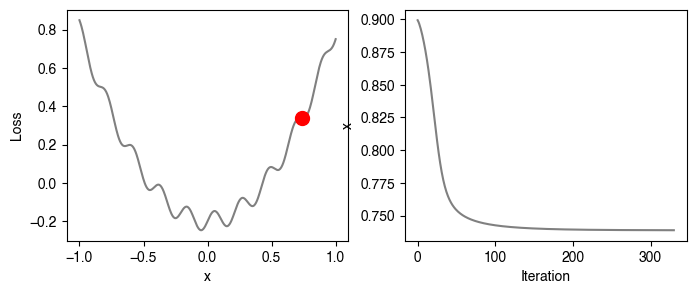

In [17]:
class GradientDescentMomentumOptimizer:
    
        def __init__(self, learning_rate=0.1, alpha=0.9, max_iter=1000, tolerance=1e-6, store_history=False):
            self.learning_rate = learning_rate
            self.alpha = alpha
            self.max_iter = max_iter
            self.tolerance = tolerance
            self.store_history = store_history
            if self.store_history:
                self.history = list()
    
        def optimize(self, df, x0):
            x = x0
            v = 0
            for i in range(self.max_iter):
                
                v = self.alpha * v - self.learning_rate * df(x)
                x_new = x + v

                if np.linalg.norm(x_new - x) < self.tolerance:
                    break
                x = x_new
    
                if self.store_history:
                    self.history.append(x_new)
    
            return x

# loss = lambda x: 0.5 * x**2 - 0.2
# loss_grad = lambda x: x

loss = lambda x: x**2 + 0.05 * np.sin(30 * x) - 0.2
loss_grad = lambda x: 2 * x + 0.05 * 30 * np.cos(30 * x)

## Solve optimization
# optimizer = GradientDescentOptimizer(learning_rate=0.3, store_history=True)
optimizer = GradientDescentMomentumOptimizer(learning_rate=0.0005, alpha=0.7, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.9)

## Plot loss
xx = np.linspace(-1, 1, 500)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(xx, loss(xx), color='gray')
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(optimizer.history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('x')

Text(0, 0.5, 'Loss')

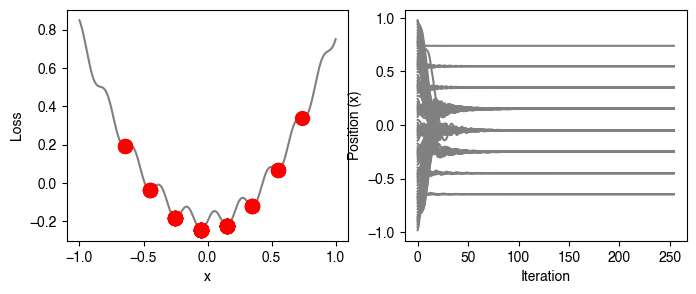

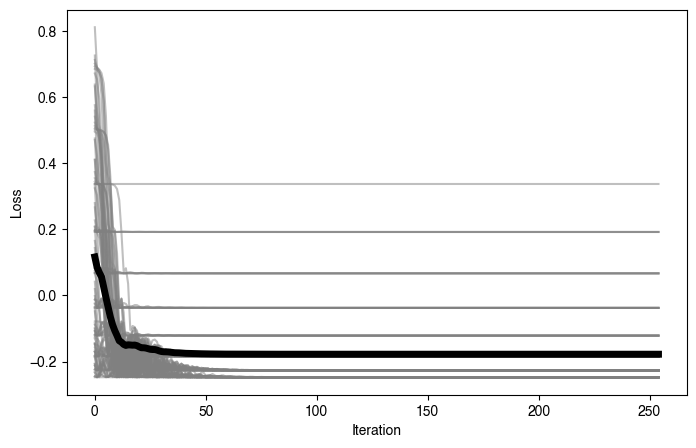

In [19]:
starting_points = np.linspace(-1, 1, 100)
optimizer = GradientDescentMomentumOptimizer(learning_rate=0.01, alpha=0.9, store_history=True)
x_opt = optimizer.optimize(loss_grad, starting_points)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(xx, loss(xx), color='gray')
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(optimizer.history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('Position (x)')

all_losses = loss(np.array(optimizer.history))
plt.figure(figsize=(8, 5))
plt.plot(all_losses, color='gray', alpha=0.5)
plt.plot(np.mean(all_losses, axis=1), color='black', lw=5)
plt.xlabel('Iteration')
plt.ylabel('Loss')


In [20]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Precompute the static background curve
yline = loss(xx)

fig, ax = plt.subplots(figsize=(7, 5))
(bg_line,) = ax.plot(xx, yline, lw=2, color='gray')
ax.set_xlabel("x")
ax.set_ylabel("Loss")
ax.set_xlim(np.min(xx), np.max(xx))
ax.set_ylim(np.min(yline) - 0.1, np.max(yline))

# Moving point (and optional trace)
(dot,) = ax.plot([], [], "ro", ms=6)
# (trace,) = ax.plot([], [], "r-", alpha=0.35)
_xtrace, _ytrace = [], []

def init():
    dot.set_data([], [])
    # trace.set_data([], [])
    _xtrace.clear(); _ytrace.clear()
    return (dot, )

def update(k):
    xk = optimizer.history[k]
    yk = loss(xk)
    dot.set_data([xk], [yk])

    # optional breadcrumb trail
    _xtrace.append(xk); _ytrace.append(yk)
    # trace.set_data(_xtrace, _ytrace)

    return (dot, )

ani = FuncAnimation(
    fig,
    update,
    frames=len(optimizer.history),
    init_func=init,
    interval=100,
    blit=True,
    repeat=True,
)
plt.close(fig)


# In-notebook video (MP4 in HTML5). For smaller notebooks, to_jshtml() is also fine.
HTML(ani.to_html5_video())

We can see several desirable properties of momentum. First, the momentum term acts to dampen oscillations near the minimum, and so it can counteract the spurious oscillations that can occur in gradient descent when the learning rate $\eta$ is too large. Second, at smaller learning rates, the momentum term allows the optimizer to find minima other than the nearest local minimum to its starting point. This is particularly useful on our particular choice of non-convex landscape, where several local minima occur at relatively large values of $x$ away from the true minimum near $x=0$.

<br><br><br><br><br><br><br><br>

### Deriving momentum

We can derive momentum by returning to our original continuous-time equation of motion, 

$$ 
    m \ddot{x} = -\gamma \dot{x} -\dfrac{dV}{dx}
$$

In discrete time, we need to approximate the second derivative as a finite difference as well,

$$
    m \dfrac{1}{\Delta t}\left(\dfrac{x(t+\Delta t) - x(t)}{\Delta t} - \dfrac{x(t) - x(t - \Delta t)}{\Delta t}\right) = -\gamma \dfrac{x(t+\Delta t) - x(t)}{\Delta t} -\dfrac{dV}{dx}
$$

We define the velocity as $v(t) = (x(t) - x(t-\Delta t))/\Delta t$, and rearranging gives
$$
    v(t+\Delta t) = \left(1 - \dfrac{\gamma \Delta t}{m}\right) v(t) - \dfrac{\Delta t}{m} \dfrac{dV}{dx}
$$
we absorb the constants into the hyperparameters $\alpha$ and $\eta$,

$$
    v(t+\Delta t) = \alpha\, v(t) - \eta\, \dfrac{dV}{dx}
$$

and 

$$
    x(t+\Delta t) = x(t) + \Delta t\, v(t+\Delta t)
$$

<br><br><br>


## When does gradient descent fail?

We saw before that the performance of gradient descent depends on the choice of learning rate $\eta$. If the learning rate is too large, the optimizer exhibits erratic dynamics that do not map onto the expected behavior in continuous-time dynamics. Can we find this critical value of $\eta$ at which the optimizer becomes unstable?

Text(0, 0.5, 'Loss')

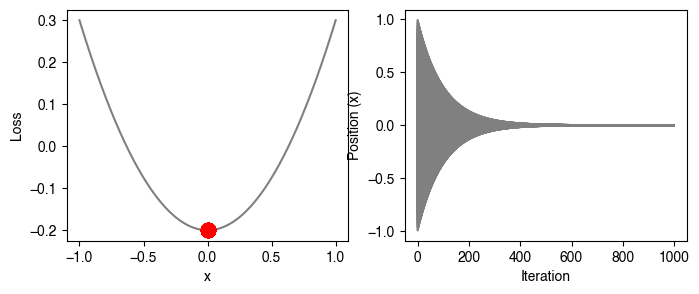

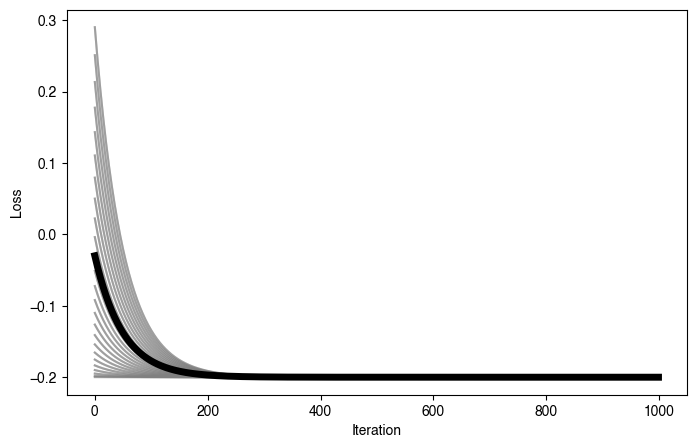

In [37]:
loss = lambda x: 0.5 * x**2 - 0.2
loss_grad = lambda x: x

starting_points = np.linspace(-1, 1, 50)
optimizer = GradientDescentOptimizer(learning_rate=0.2, store_history=True)
optimizer = GradientDescentOptimizer(learning_rate=1.99, store_history=True)
# optimizer = GradientDescentOptimizer(learning_rate=2.0, store_history=True)
# optimizer = GradientDescentOptimizer(learning_rate=2.1, store_history=True)
x_opt = optimizer.optimize(loss_grad, starting_points)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(xx, loss(xx), color='gray')
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(optimizer.history, color='gray')
plt.xlabel('Iteration')
plt.ylabel('Position (x)')

all_losses = loss(np.array(optimizer.history))
plt.figure(figsize=(8, 5))
plt.plot(all_losses, color='gray', alpha=0.5)
plt.plot(np.mean(all_losses, axis=1), color='black', lw=5)
plt.xlabel('Iteration')
plt.ylabel('Loss')


In [35]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Precompute the static background curve
yline = loss(xx)

fig, ax = plt.subplots(figsize=(7, 5))
(bg_line,) = ax.plot(xx, yline, lw=2, color='gray')
ax.set_xlabel("x")
ax.set_ylabel("Loss")
ax.set_xlim(np.min(xx), np.max(xx))
ax.set_ylim(np.min(yline), np.max(yline))

# Moving point (and optional trace)
(dot,) = ax.plot([], [], "ro", ms=6)
# (trace,) = ax.plot([], [], "r-", alpha=0.35)
_xtrace, _ytrace = [], []

def init():
    dot.set_data([], [])
    # trace.set_data([], [])
    _xtrace.clear(); _ytrace.clear()
    return (dot, )

def update(k):
    xk = optimizer.history[k]
    yk = loss(xk)
    dot.set_data([xk], [yk])

    # optional breadcrumb trail
    _xtrace.append(xk); _ytrace.append(yk)
    # trace.set_data(_xtrace, _ytrace)

    return (dot, )

ani = FuncAnimation(
    fig,
    update,
    frames=len(optimizer.history),
    init_func=init,
    interval=100,
    blit=True,
    repeat=True,
)
plt.close(fig)


# In-notebook video (MP4 in HTML5). For smaller notebooks, to_jshtml() is also fine.
HTML(ani.to_html5_video())

python3.13(1886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


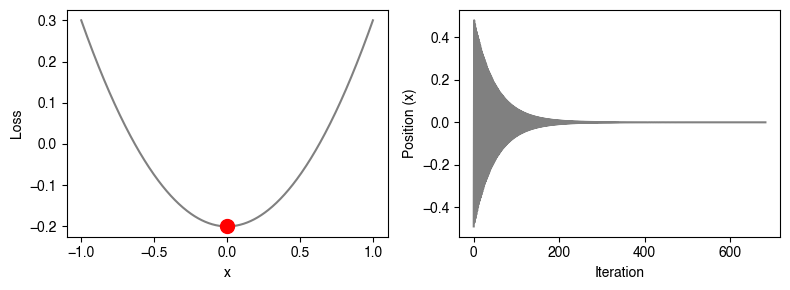

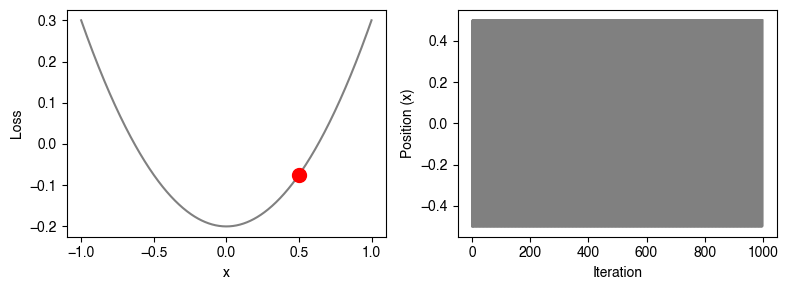

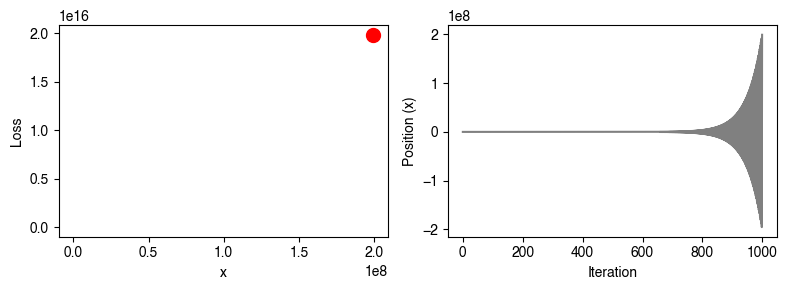

In [81]:
loss = lambda x: 0.5 * x**2 - 0.2
loss_grad = lambda x: x

for lr in [1.98, 2.0, 2.02]:
    optimizer = GradientDescentOptimizer(store_history=True, learning_rate=lr)
    x_opt = optimizer.optimize(loss_grad, 0.5)

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(xx, loss(xx), color='gray')
    plt.plot(x_opt, loss(x_opt), 'ro')
    plt.xlabel('x')
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(optimizer.history, color='gray')
    plt.xlabel('Iteration')
    plt.ylabel('Position (x)')

    plt.tight_layout()

### The sharpness bound

Gradient descent fails to converge when the learning rate exceeds some critical threshold. If we imagine the discrete time dynamics in the quadratic case, the force acting on the particle is proportional to the distance from the minimum, $F = -kx$. If we take a discrete time step of size $\Delta t$, then the position at the next timestep the absence of momentum is given by
$$
    x(t + \Delta t) = x(t) - k x(t).
$$

We know that this system has a fixed point when $x(t + \Delta t) = x(t)$,
$$
    x(t) = x(t) - k x(t).
$$
corresponding to the equilibrium,
$$
    x(t) = 0.
$$


<br><br><br><br><br><br>
#### Are there any other fixed points?
We consider the case of a period-2 oscillation, in which case $x(t + 2\Delta t) = x(t)$. If we think of a fixed point as a period-1 limit cycle, then we can think of a period-2 limit cycle as a limit cycle that returns to its starting point every two timesteps. To look for this case, we start by writing out the first two steps of the dynamics:
$$
    x(t + \Delta t) = x(t) - k x(t).
$$
$$
    x(t + 2\Delta t) = x(t + \Delta t) - k x(t + \Delta t).
$$
We can plug the first equation into the first equation to eliminate all appearances of $x(t + \Delta t)$. 
$$
    x(t + 2\Delta t) = x(t) - k x(t) - k \bigg(x(t) - k x(t)\bigg).
$$

We can use the limit cycle condition $x(t + 2\Delta t) = x(t)$ to eliminate all appearances of $x(t + \Delta t)$, yielding
$$
    x(t) = x(t) - 2 k x(t) + k^2 x(t).
$$
Curiously, $x(t)$ cancels out of this equation (this is a consequence of our dynamics being linear). The resulting solutions should just hold for any $x(t)$, and so we can solve for the critical value of $k$ that leads to a period-2 limit cycle.
$$
    0 = - 2 k  + k^2 = k (k - 2).
$$
The case $k=0$ corresponds the trivial case where there is no force at all, and so the particle does not move. The $k=2$ case means that, at that specific value of the stiffness, the system exhibits period-2 oscillations. When $k > 2$, the oscillations will tend to grow (the optimizer overshoots and the limit cycle grows), while when $k < 2$, the oscillations will tend to shrink (the optimizer undershoots and converges to the fixed point). 

In general, the critical value of $\eta$ at which the optimizer becomes unstable is given by $\eta = 2 / f''$, where $f$'' is the curvature of the loss function at the minimum. This is known as the *sharpness bound*.


The sharpness bound is a key demonstration of a core idea in optimization: second order information, when available, can be very useful for controlling the rate of optimization. This motivates the use of second-order methods.

<br><br><br><br><br><br><br><br><br><br><br>

## Second-order methods and Newton's method

Newton's method is a *second order method*, which aims to improve convergence using information about the local geometry of a loss landscape. Suppose that our optimizer's initial guess is $x_k$ and our objective function is $f(x)$. We perform a second-order Taylor expansion around the guess,
$$
    f(x_{k}+ h)\approx f(x_{k})+f'(x_{k})h +{\frac {1}{2}}f''(x_{k})h^{2}.
$$
Instead of treating the discretization $h$ is a hyperparameter, we instead pick the step size that minimizes difference between the original function and its second-order Taylor expansion,
$$
    \displaystyle 0={\frac {\rm {d}}{{\rm {d}} h}}\left(f(x_{k})+f'(x_{k})h+{\frac {1}{2}}f''(x_{k})h^{2}\right)=f'(x_{k})+f''(x_{k})h,
$$
Solving this equation, we arrive at 
$$
h^* = -{\frac {f'(x_{k})}{f''(x_{k})}},
$$

Having optimized the approximant, we now update the position of $x$ using that optimal step $x_{k+1} = x_{k} + h^*$. This results in the **Newton's method update rule**,
$$
   x_{k+1} = x_{k} - {\frac {f'(x_{k})}{f''(x_{k})}}.
$$

Basically, in a single timestep Newton's method we approximate the function locally as a parabola, and we then jump to the optimum of that parabolic approximant. Newton's method therefore consists of optimizing a global function by optimizing a series of local approximants. We can think of Newton's method as taking the largest step that we can get away with, without crossing the sharpness bound.

<br><br>


Text(0, 0.5, 'x')

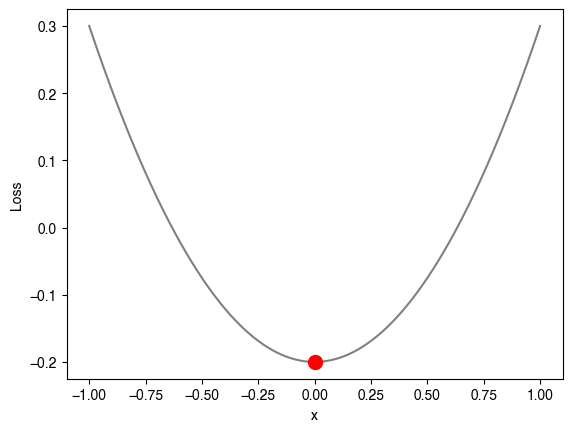

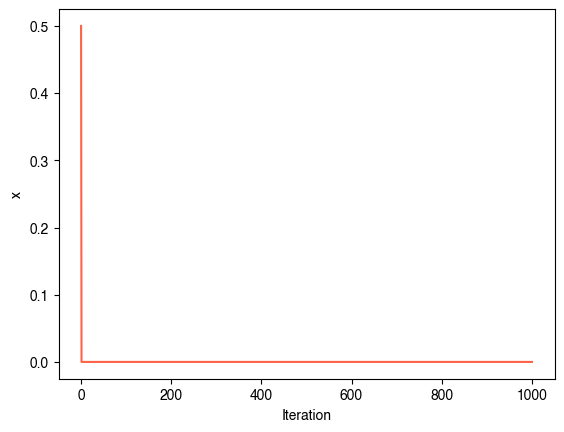

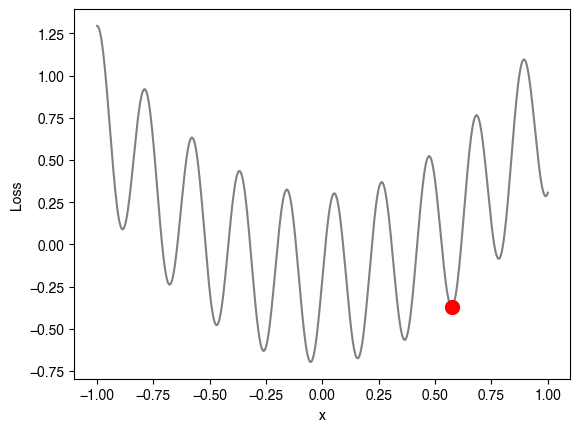

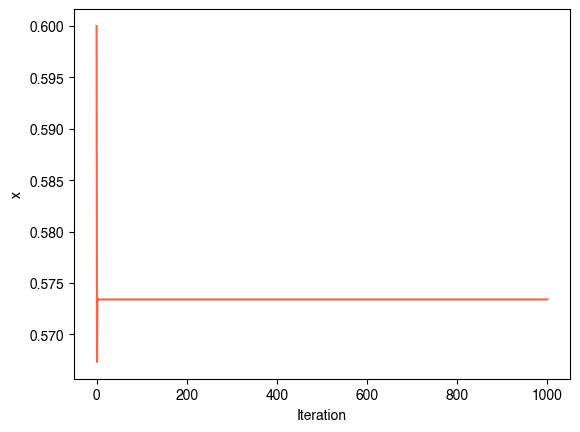

In [39]:
def finite_difference(f, x, dx=1e-5, order=1):
    """
    Compute the derivative of a function using centered finite differences

    Args:
        f: The function to differentiate
        x: The point at which to differentiate
        dx: The step size
        order: The order of the derivative to compute
    """
    if order == 1:
        return (f(x + dx / 2) - f(x - dx / 2)) / dx
    elif order == 2:
        return (f(x + dx) - 2 * f(x) + f(x - dx)) / dx**2
    else:
        raise ValueError('Only first and second order derivatives are supported')

class NewtonOptimizer:
    """
    Newton's method for finding the optima of a function in one dimension

    Parameters:
        tolerance (float): The tolerance for the stopping criterion
        max_iterations (int): The maximum number of iterations to perform
        store_history (bool): Whether to store the history of the optimization
    """
    def __init__(self, tolerance=1e-6, max_iterations=1000, store_history=False):
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.store_history = store_history
        if store_history:
            self.history = list()

    def optimize(self, f, x0, df=None):

        x = x0

        if self.store_history:  self.history.append(np.copy(x))
        for _ in range(self.max_iterations):

            # Approximate the derivatives with finite differences
            fd = finite_difference(f, x, order = 1)
            fdd = finite_difference(f, x, order = 2)
            x = x - fd / fdd


            ## Stop early if the local concavity is zero
            if np.abs(fdd) < self.tolerance:
                break
            

            if self.store_history: self.history.append(np.copy(x))
        return x


## Convex function
loss = lambda x: 0.5 * x**2 - 0.2
optimizer = NewtonOptimizer(store_history=True)
xstar = optimizer.optimize(loss, 0.5)

plt.figure()
plt.plot(xx, loss(xx), color='gray')
plt.plot(xstar, loss(xstar), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

# ## Non-convex function
loss = lambda x :  x**2 + 0.5 * np.sin(30 * x) - 0.2
optimizer = NewtonOptimizer(store_history=True)
xstar = optimizer.optimize(loss, 0.6)

plt.figure()
plt.plot(xx, loss(xx), color='gray')
plt.plot(xstar, loss(xstar), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')


In [40]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Precompute the static background curve
yline = loss(xx)

fig, ax = plt.subplots(figsize=(7, 5))
(bg_line,) = ax.plot(xx, yline, lw=2, color='gray')
ax.set_xlabel("x")
ax.set_ylabel("Loss")
ax.set_xlim(np.min(xx), np.max(xx))
ax.set_ylim(np.min(yline), np.max(yline))

# Moving point (and optional trace)
(dot,) = ax.plot([], [], "ro", ms=6)
# (trace,) = ax.plot([], [], "r-", alpha=0.35)
_xtrace, _ytrace = [], []

def init():
    dot.set_data([], [])
    # trace.set_data([], [])
    _xtrace.clear(); _ytrace.clear()
    return (dot, )

def update(k):
    xk = optimizer.history[k]
    yk = loss(xk)
    dot.set_data([xk], [yk])

    # optional breadcrumb trail
    _xtrace.append(xk); _ytrace.append(yk)
    # trace.set_data(_xtrace, _ytrace)

    return (dot, )

ani = FuncAnimation(
    fig,
    update,
    frames=len(optimizer.history),
    init_func=init,
    interval=100,
    blit=True,
    repeat=True,
)
plt.close(fig)


# In-notebook video (MP4 in HTML5). For smaller notebooks, to_jshtml() is also fine.
HTML(ani.to_html5_video())

python3.13(4221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



### What if we don't know the derivatives of $f(x)$?

In our previous examples, we've taken for granted that we have a function available that gives the exact value at the derivative at any point $x4 on the landscape. However, this is not always the case. We can always call the loss function at nearby points, in order to estimate the derivative.
$$
    f'(x) \approx \dfrac{f(x + \Delta x / 2) - f(x - \Delta x / 2)}{\Delta x}
$$
$$
f''(x) \approx \dfrac{f(x + \Delta x) - 2 f(x) + f(x - \Delta x)}{\Delta x^2}
$$
where $\Delta x / x \ll 1$. 

Here we have used central finite differences, but we could also use forward finite differences
$$
    f'(x) \approx \dfrac{f(x + \Delta x) - f(x)}{\Delta x}
$$
$$
    f''(x) \approx \dfrac{f(x + 2 \Delta x) - 2 f(x + \Delta x) + f(x)}{\Delta x^2}
$$
Or, analogously, backwards finite differences.There also exist [higher-order finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference), as well as multivariate generalizations. Notice how the coefficients of the first and second derivatives are Pascal's triangle. Newton's method with a finite difference approximation of the second derivaive is sometimes called the "secant" method.

### Why is differentiability important?

A key goal of modern machine learning objective functions and network architectures is to ensure that the loss function is differentiable with respect to all of the parameters of the model, so that gradients can be computed exactly. Why not just use finite difference approximations? For one, finite difference approximations are not exact, tend to fail when we need them to be the most accurate, such as in rapidly changing regions of the landscape. More importantly, finite difference approximations scale poorly with dimensionality. In 1D, we had to call the objective function five times in Newton's method just to get first-order finite difference operators for the first and second derivatives of the potential. For a $d$-dimensional input space, a first-order central finite difference approximation of the gradient requires $2 d$ calls to the objective function, while a second-order finite difference approximation of the Hessian requires $2 d^2 + 1$ calls to the objective function.

<br><br><br><br><br><br><br><br><br><br><br>

#### Interpreting the Newton optimizer

We can think of the Newton optimizer as a *second order method*. The update rule for $x$ was

$$
    x \leftarrow x - {\frac{f'}{f''}}.
$$

The numerator of the update is just the local gradient step: we take a step in the direction of descent, at a rate proportional to the slope along that direction. The denominator we can interpret as an "adaptive learning rate": we take larger steps as the local landscape gets flatter, and smaller steps in very convex areas.

Newton's method is not quite as straightforward to physically interpret as gradient descent. We are still minimizing some potential function, but now the relaxation rate depends inversely on the local curvature of the potential function. In first-order dynamics, the learning rate inverts the damping constant, so Newton's method is like a system where the damping constant is proportional to the curvature of the potential function.

<br><br><br><br><br><br><br><br><br><br>